In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sc
# from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

In [3]:
#defining transform
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)) #cifar10 mean and std of stackoverflow
])

In [4]:
#seperate transform for test data cuz i used random crop and random horizontalflip for training the data
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

real_testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=eval_transform
)
real_test_loader = DataLoader(real_testset, batch_size=64, shuffle=False)

c:\Users\nithe\Documents\projects\cifar10\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [5]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

In [6]:
image, label = trainset[0]

print(f"Image Type: {type(image)}") 
print(f"Label Type: {type(label)}") 

print(f"Image Shape: {image.shape}") 

print(f"Label Index: {label}")
print(f"Class Name: {trainset.classes[label]}") 

Image Type: <class 'torch.Tensor'>
Label Type: <class 'int'>
Image Shape: torch.Size([3, 32, 32])
Label Index: 6
Class Name: frog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49460602..1.5633953].


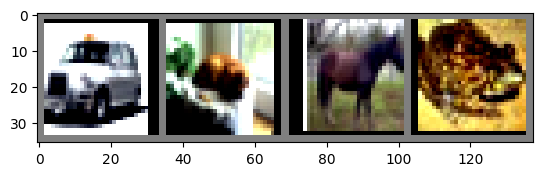

automobile cat   horse frog 


In [7]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0) 

dataiter = iter(trainloader)
images, labels = next(dataiter) 

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(4)))

In [8]:
#spliting ratio
train_ratio = 0.8
validation_ratio = 0.2

#define sizes
data_size = len(trainset)
train_size = int(train_ratio * data_size)
validation_size = data_size - train_size

In [9]:
#spliting data
train_set, valid_set = random_split(trainset, [train_size, validation_size])
print(len(train_set))   
print(len(valid_set))

40000
10000


In [10]:
#loading the data
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(valid_set, batch_size=64, shuffle=False)

In [11]:
device = torch.device("cuda")

resnet34_model = torchvision.models.resnet34(num_classes=10)

resnet34_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet34_model.maxpool = nn.Identity()

resnet34_model = resnet34_model.to(device)

In [12]:
#loss function
loss_func = nn.CrossEntropyLoss()

# print(linear_model.parameters())

optimizer = optim.SGD(resnet34_model.parameters(), lr=0.1, momentum=0.2, weight_decay=5e-4)

scheduler = sc.MultiStepLR(optimizer, milestones=[15, 22], gamma=0.1)

In [13]:
#training model
def epoch(epoch_index):

    resnet34_model.train()
    running_loss = 0.0
    epoch_loss_sum = 0.0 
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_data):
        inputs, labels = inputs.to(device), labels.to(device)

        #zeroing gradients
        optimizer.zero_grad()

        #just inputs to make the model predict
        output = resnet34_model(inputs)
        
        #comparing the guessing vs ground truth
        loss = loss_func(output, labels)
        loss.backward()

        #adjust weights
        optimizer.step()
        
        #sending loss to the running function
        bs = inputs.size(0)
        running_loss += loss.item()
        epoch_loss_sum += loss.item() * bs
        total_samples += bs

        if i % 100 == 99:
            print(f'  batch {i + 1} loss: {running_loss/100:.4f}')
            running_loss = 0.

    return epoch_loss_sum / total_samples


In [14]:
def validate_epoch():

    resnet34_model.eval()
    loss_sum = 0.0
    total_samples = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_data:
            inputs, labels = inputs.to(device), labels.to(device)
            
            #getting raw predictions 
            outputs = resnet34_model(inputs)
            
            #calculating loss
            loss = loss_func(outputs, labels)
            
            bs = inputs.size(0)
            loss_sum += loss.item() * bs
            total_samples += bs
            
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            
    avg_loss = loss_sum / total_samples
    accuracy = 100.0 * correct / total_samples
    return avg_loss, accuracy

In [17]:
epochs = 10

for i in range(epochs):
    # Call the separate functions
    train_loss = epoch(i)
    scheduler.step()
    val_loss, val_acc = validate_epoch()
    
    print(f"Epoch {i}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

  batch 100 loss: 0.9471
  batch 200 loss: 0.8865
  batch 300 loss: 0.8556
  batch 400 loss: 0.8261
  batch 500 loss: 0.8509
  batch 600 loss: 0.7983
Epoch 0: Train Loss: 0.8590 | Val Loss: 0.8089 | Accuracy: 71.72%
  batch 100 loss: 0.7449
  batch 200 loss: 0.7331
  batch 300 loss: 0.7405
  batch 400 loss: 0.7374
  batch 500 loss: 0.7191
  batch 600 loss: 0.6915
Epoch 1: Train Loss: 0.7261 | Val Loss: 0.9217 | Accuracy: 69.72%
  batch 100 loss: 0.6440
  batch 200 loss: 0.6467
  batch 300 loss: 0.6233
  batch 400 loss: 0.6328
  batch 500 loss: 0.6195
  batch 600 loss: 0.5855
Epoch 2: Train Loss: 0.6265 | Val Loss: 0.8480 | Accuracy: 73.22%
  batch 100 loss: 0.5612
  batch 200 loss: 0.5719
  batch 300 loss: 0.5645
  batch 400 loss: 0.5537
  batch 500 loss: 0.5732
  batch 600 loss: 0.5654
Epoch 3: Train Loss: 0.5643 | Val Loss: 0.7961 | Accuracy: 73.64%
  batch 100 loss: 0.5139
  batch 200 loss: 0.4970
  batch 300 loss: 0.5230
  batch 400 loss: 0.5200
  batch 500 loss: 0.5051
  batch 600

In [18]:
test_data = real_test_loader
test_loss, test_acc = validate_epoch()
print(f"Test Acc: {test_acc:.2f}%  | Test Loss: {test_loss:.4f}")

Test Acc: 82.77%  | Test Loss: 0.5096
